# Natural Language Processing with Disasters
----------------------------------------------------------------------------

**Author**: Rafael Oliva

## Introduction
----------------------------------------------------------------------------

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. 

In this project we will be using Text Classification with LSTM.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 300
import seaborn as sns
import re
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from collections import defaultdict
from collections import  Counter
import string
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')


In [2]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in 'C:\\Users\\darkk\\Documents\\DATA SCIENCE\\06 Natural Language Processing with Disaster Tweets': ['.ipynb_checkpoints', 'data', 'NLP_twitter.py', 'NLP_twitter_notebook.ipynb', 'NLP_twitter_notebook.pdf']


In [3]:
train = pd.read_csv("./data/train.csv")
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
test = pd.read_csv("./data/test.csv")
test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


## Data Understanding
----------------------------------------------------------------------------

Before we continue with anything we will begim with Exploratory Data Analysis on the data set. This will help us understand what we are up against and how the data is behaving so we can construct a better model to decifer each tweet. 

So as a first step we will visualize the class distribution in our data set. There are only two classes in here; 0 and 1. 

0    4342
1    3271
Name: target, dtype: int64


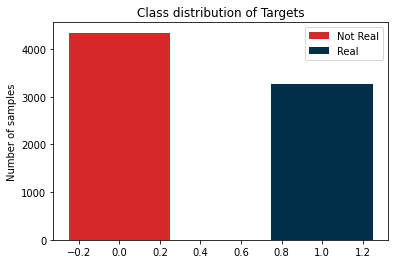

In [5]:
print(train.target.value_counts())

class_0 = train.target.value_counts()[0]
class_1 = train.target.value_counts()[1]
plt.bar(0, class_0, 0.5, label = 'Not Real', color = '#d62828')
plt.bar(1, class_1, 0.5, label = 'Real', color = '#003049')
plt.legend()
plt.ylabel('Number of samples')
plt.title('Class distribution of Targets')
plt.show()

We can see from the 'Class distribution of Targets' graph, there are more not real disaster tweets than there are real disasters tweets. 

Now, we will do a simple statistcs analysis at a character level, word level and sentence level.

We will start with the **character analysis in a tweet**

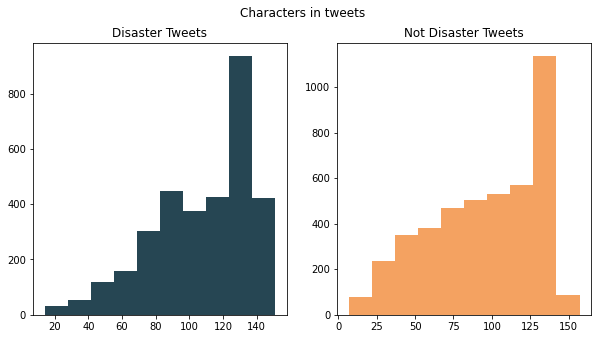

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

tweet_len = train[train['target'] == 1]['text'].str.len()
ax1.hist(tweet_len, color = '#264653')
ax1.set_title('Disaster Tweets')

tweet_len = train[train['target'] == 0]['text'].str.len()
ax2.hist(tweet_len, color = '#f4a261')
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Characters in tweets')
plt.show()


The distribution of both classes of tweets seems to be the same. From 120 to 140 characters in a single tweet seems to be the most common among both classes.

As the next step, we will analyses the amount of words in the tweets from our training data set.

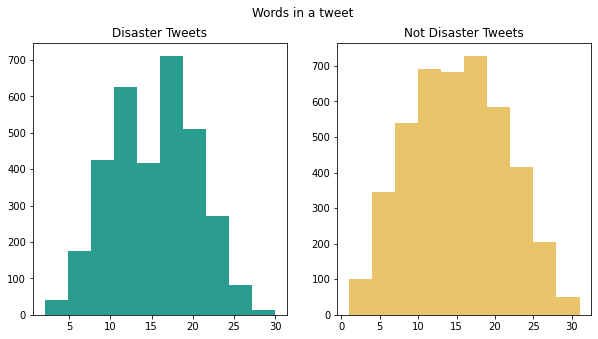

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

tweet_len = train[train['target'] == 1]['text'].str.split().map(lambda word: len(word))
ax1.hist(tweet_len, color = '#2a9d8f')
ax1.set_title('Disaster Tweets')

tweet_len = train[train['target'] == 0]['text'].str.split().map(lambda word: len(word))
ax2.hist(tweet_len, color = '#e9c46a')
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Words in a tweet')
plt.show()


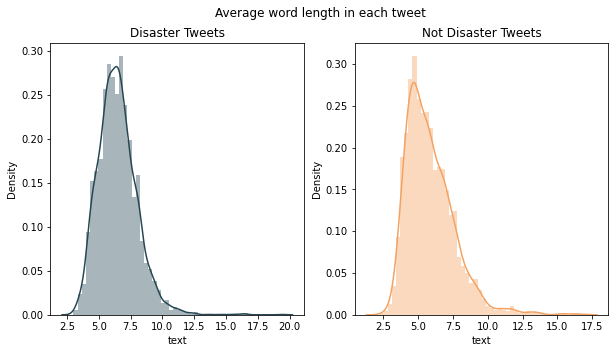

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
word = train[train['target'] == 1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax1, color = '#264653')
ax1.set_title('Disaster Tweets')

word = train[train['target'] == 0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax2, color = '#f4a261')
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Average word length in each tweet')
plt.show()


The average word length in each tweet depending of the class is represented by the graph above. Here we can visualize that for the tweets that are disaster related, have an average of about 7 word per tweet. While the tweets that are not disaster related, have about 5.5 words in average per tweet. 

As the next step, we will analyze the amount of stop words that there are within each class of tweet in our target label. 

In [9]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [10]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top0=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

In [11]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top1=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 


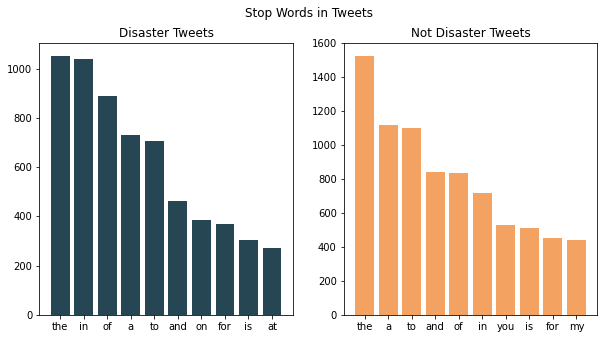

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,5))

x, y = zip(*top1)
ax1.bar(x,y, color = '#264653')
ax1.set_title('Disaster Tweets')

x, y = zip(*top0)
ax2.bar(x,y, color = '#f4a261')
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Stop Words in Tweets')
plt.show()

We can see that in both cases the stop word "the" dominates in the data set. While in the Disaster tweets class, the "in" stop word is a clsoe second. But in the tweets that are not disaster related, the "a" is a far second. 

Now, we will analyze the punctuations on the data set from the related distaster tweets as well as the non-related disaster tweets. We will start with the tweets related to disasters.

In [13]:
#Disaster tweets
dic1=defaultdict(int)
special1 = string.punctuation
for i in (corpus):
    if i in special1:
        dic1[i]+=1

In [14]:
#Not Disaster tweets
dic0=defaultdict(int)
special0 = string.punctuation
for i in (corpus):
    if i in special0:
        dic0[i]+=1

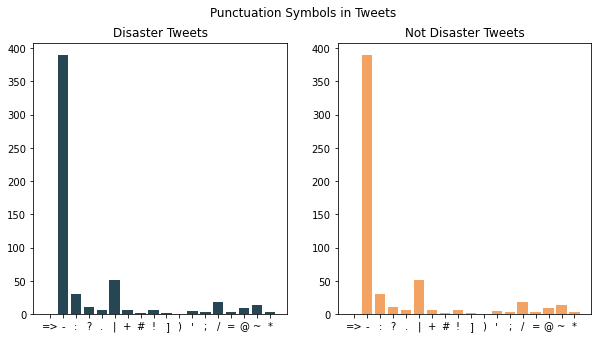

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,5))

x, y = zip(*dic1.items())
ax1.bar(x,y, color = '#264653')
ax1.set_title('Disaster Tweets')

x, y = zip(*dic0.items())
ax2.bar(x,y, color = '#f4a261')
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Punctuation Symbols in Tweets')
plt.show()

In the above grpahs, we can appreciate that the puntuations symbols are not relevant in being a disaster related tweet or not. Due to the fact that the punctuation symbols are basically the same in both classes. At least we know now. 

The following step involves in visualizing the most common words in our data set. This will help to analyze on how much data cleaning we will have to do.

In [16]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

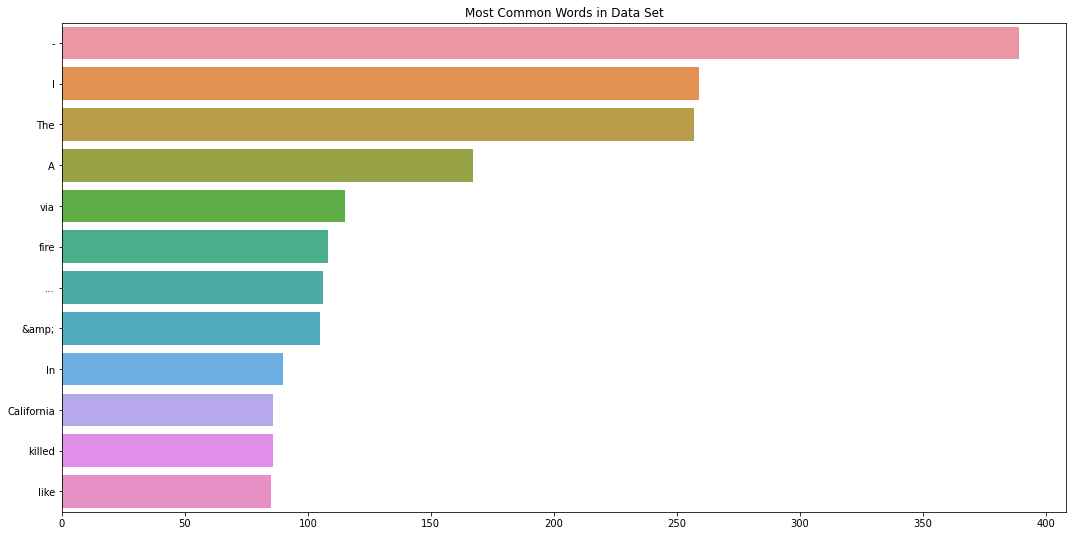

In [17]:
plt.figure(figsize = (18,9))
sns.barplot(x = y, y = x).set(title = 'Most Common Words in Data Set')
plt.show()

So... This shows that there has to be a lot of data cleaning. We can see that only a couple of words are relevant to the porpuse of this project like; 'fire' and 'killed'. 

We will make a N-gram analysis over the tweets. 

N-grams are continuous sequences of words or symbols or tokens in a document. In technical terms, they can be defined as the neighbouring sequences of items in a document. They come into play when we deal with text data in NLP(Natural Language Processing) tasks.

In this case, the n-gram analysis will be a bigram (n = 2). So we can check the most como bigrams in the tweets.

In [18]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

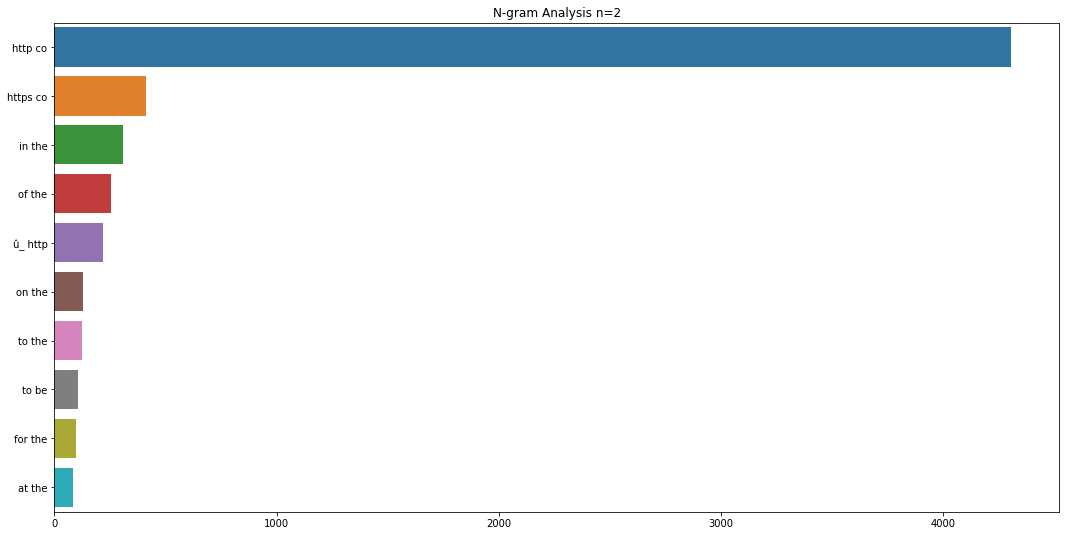

In [19]:
plt.figure(figsize=(18,9))
top_tweet_bigrams=get_top_tweet_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x).set(title = 'N-gram Analysis n=2')
plt.show()

Again, this is not what we need for the analysis. So, there is a lot of clening to do in here too. 

We have fanalized the phase of data understanding with our exploratory data analysis aproach. So now that we know what needs to be cleanes, what's useful and what's not, we will be proceeding with cleaning our data.

## Data Cleaning and Data Preparation
----------------------------------------------------------------------------

In this phase of the project we will make each tweet readable and more understandable. Where we will remove the usernames of the text make everything lower case as well we will remove puntuations from each tweet together with removing every stop word and lemmatize the words that we are looking to make our keywords. We will consider the data analysis phase so that we can remove anything that we know for sure has no statistical relationship with the study.

In [20]:
df = pd.concat([train, test])
print(df.shape)
df.head(10)

(10876, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1.0
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1.0
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1.0
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1.0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1.0


Firstly we will make the every text of the data set a lower case. So everything that we do at this point has the same range of values. If we leave the capital letters it will mess with the values and make cases for us to consider.

In [21]:
df['text'] = df['text'].apply(lambda text:text.lower())
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1.0
1,4,NaN,NaN,forest fire near la ronge sask. canada,1.0
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1.0


We will remove the urls together with the html tags

In [22]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

example = "New competition launched :https://www.kaggle.com/c/nlp-getting-started"

remove_URL(example)

'New competition launched :'

In [23]:
#removing urls from data frame
df['text'] = df['text'].apply(lambda x: remove_URL(x))

In [24]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

remove_html(example)

'\nReal or Fake\nKaggle \ngetting started\n'

In [25]:
#removing urls from data frame
df['text'] = df['text'].apply(lambda x: remove_html(x))

As we all know, almost everyone uses emojis for texting or to post on facebook or instagram. Twitter is no exceptio as well. So now we will remove every emoji from our data frame for better results.

In [26]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [27]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

Refering back to the graph that visualized the most common words in the data set, we saw that there are punctuations in the top places. It means that punctuations will cause an issue. We have to get rid of them as well to avoid skueing the result. Due to the fact that we saw punctuations are basically the same in both related and non related disaster tweets. 

In [28]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king!"

print(remove_punct(example))

I am a king


In [29]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

Now that our text is in a shorter value range (only lower case) we will start the process of "Lemmatization".

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item (easier to analyze). This does morphological analysis of the each of the words so they are simpler to classify.An example can be:

- rocks: rock
- loving: love
- better: good

This help us get a better context for each of the tweets and make our computer understand what's the reason of each tweet (disaster related tweet or non-related disaster).

In [30]:
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda t:lemmatizer.lemmatize(t))
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1.0
5,8,NaN,NaN,rockyfire update california hwy 20 closed in ...,1.0
6,10,NaN,NaN,flood disaster heavy rain causes flash floodin...,1.0
7,13,NaN,NaN,im on top of the hill and i can see a fire in ...,1.0
8,14,NaN,NaN,theres an emergency evacuation happening now i...,1.0
9,15,NaN,NaN,im afraid that the tornado is coming to our area,1.0


## Data Visualization
----------------------------------------------------------------------------